# **1. Installing Libraries**

In [1]:
!pip install torch-summary

In [2]:
!pip install --upgrade torchsummary

In [3]:
!pip install torch

In [4]:
!pip install torchvision

In [5]:
!pip install split-folders

# **2. Importing Libraries**

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms 
import torch.nn.functional as F
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import numpy as np
import pathlib
import splitfolders
from torchsummary import summary

import torch
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from sklearn.metrics import confusion_matrix
import seaborn as sns

# **3. Loading Dataset**

In [7]:
Dataset_path = pathlib.Path('/kaggle/input/rice-image-dataset/Rice_Image_Dataset')

# **4. Introduction**

In this project, we have embarked on an exploration of image classification using the Rice_Image dataset.

The primary objective of this endeavor is to construct and train convolutional neural network (CNN) models capable of accurately classifying these rice images.

To accomplish this, we employed one of the most popular deep learning frameworks: PyTorch.

**4.1 Introduction to Dataset**

The Rice_Image dataset is a rich collection of 75,000 images meticulously categorized into five distinct classes: 'Arborio,' 'Basmati,' 'Ipsala,' 'Jasmine,' and 'Karacadag.'

These images are of dimensions 250x250 pixels, providing ample visual information to enable accurate classification.

The dataset's diversity reflects the unique characteristics of each rice type, making it an ideal candidate for showcasing the potential of CNN models in image classification tasks.

**4.2 Pytorch Approach**

In the PyTorch framework, we concentrated on a single model's journey through data preprocessing, architecture construction, training, and evaluation.

Utilizing the capabilities of PyTorch, we designed a CNN model with multiple convolutional and pooling layers to capture nuanced image features. We meticulously executed training loops, closely monitoring loss and accuracy metrics to ensure the model's effective convergence.

Moreover, we visualized the training and validation progress to gain valuable insights into the model's learning trajectory.

# **5. Preparing Dataset**

**5.1 Splitting the data into three folders: Train, Validation, and Test**

In [8]:
splitfolders.ratio(Dataset_path, output='Images', seed=42, ratio=(.7,.15,.15))

Copying files: 75000 files [08:04, 154.77 files/s]


**5.2 Data Preprocessing: Image Transformation and Normalization**

In the upcoming steps, we focus on improving our dataset. We start by making some changes to the images, like flipping them, which adds variety to the training process.

Additionally, we calculate the average color and color variation across all the images. These values give us insights into the typical colors and patterns in the dataset.

In [9]:
# Define transformations
transform = transforms.Compose([
    transforms.Resize((250, 250)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])

# Load the train dataset
train_dataset = ImageFolder('Images/train', transform=transform)

# Create a DataLoader for the train dataset
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Calculate mean and std
mean = 0.0
std = 0.0
num_samples = len(train_dataset)
for data, _ in train_loader:
    batch_samples = data.size(0)
    data = data.view(batch_samples, data.size(1), -1)
    mean += data.mean(2).sum(0)
    std += data.std(2).sum(0)

mean /= num_samples
std /= num_samples

print("Calculated Mean:", mean)
print("Calculated Std:", std)

Calculated Mean: tensor([0.1179, 0.1189, 0.1229])
Calculated Std: tensor([0.2851, 0.2875, 0.2989])


Now, we use the calculated average color and color variation to adjust the images further.

This adjustment helps our machine learning models work better by making the images more consistent and easier to understand.

These enhancements contribute to the effectiveness of our models when working with the rice image dataset.

In [10]:
transform = transforms.Compose([
    transforms.Resize((250, 250)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.1179, 0.1189, 0.1229], std=[0.2851, 0.2875, 0.2989])
])

train_dataset = ImageFolder('Images/train', transform=transform)
validation_dataset = ImageFolder('Images/val', transform=transform)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=batch_size)

# **6. Visualising the Data**

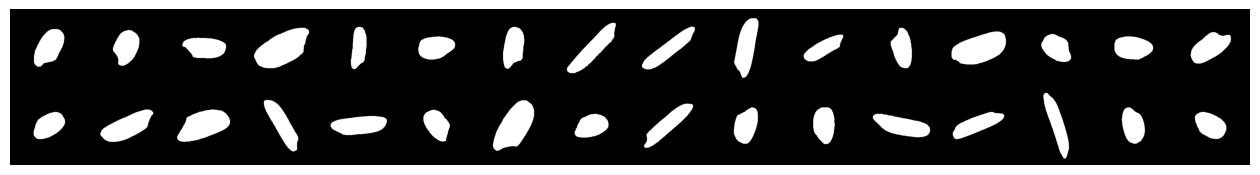

In [11]:
# Iterate over the first batch of the train_loader
for images, _ in train_loader:
    plt.figure(figsize=(16, 8))
    grid_img = make_grid(images, nrow=16)
    plt.imshow(grid_img.permute(1, 2, 0))
    plt.axis("off")
    plt.show()
    break

# **7. Modeling**

**7.1 Defining Convolutional Neural Network**

In [12]:
class RiceCNN(nn.Module):
    def __init__(self, num_classes):
        super(RiceCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64 * 62 * 62, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 62 * 62)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Create an instance of the model
model1 = RiceCNN(5)

**7.2 Setting Loss and Optimizer for Training the Model**

In [13]:
criterion = nn.CrossEntropyLoss()  # For multi-class classification
optimizer = optim.Adam(model1.parameters(), lr=0.001)

In [14]:
#Configuring Device and Moving Model to GPU (if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model1.to(device)

RiceCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=246016, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=5, bias=True)
)

In [15]:
print(f"Using {device} device")

Using cuda device


**7.3 Training and Validation Monitoring: Tracking Loss and Accuracy**

In [16]:
# Initialize empty lists to store training history
train_loss_history = []
train_acc_history = []
val_loss_history = []
val_acc_history = []

num_epochs = 30

for epoch in range(num_epochs):
    model1.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model1(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_accuracy = correct_train / total_train

    train_loss_history.append(train_loss)
    train_acc_history.append(train_accuracy)

    # Validation phase
    model1.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for images, labels in validation_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model1(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_loss /= len(validation_loader)
    val_accuracy = correct_val / total_val

    val_loss_history.append(val_loss)
    val_acc_history.append(val_accuracy)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2%}, "
          f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2%}")

Epoch [1/30], Train Loss: 0.1125, Train Accuracy: 96.18%, Validation Loss: 0.0380, Validation Accuracy: 98.91%
Epoch [2/30], Train Loss: 0.0430, Train Accuracy: 98.63%, Validation Loss: 0.0433, Validation Accuracy: 98.70%
Epoch [3/30], Train Loss: 0.0343, Train Accuracy: 98.94%, Validation Loss: 0.0224, Validation Accuracy: 99.24%
Epoch [4/30], Train Loss: 0.0279, Train Accuracy: 99.12%, Validation Loss: 0.0171, Validation Accuracy: 99.49%
Epoch [5/30], Train Loss: 0.0287, Train Accuracy: 99.16%, Validation Loss: 0.0362, Validation Accuracy: 98.95%
Epoch [6/30], Train Loss: 0.0213, Train Accuracy: 99.34%, Validation Loss: 0.0146, Validation Accuracy: 99.56%
Epoch [7/30], Train Loss: 0.0197, Train Accuracy: 99.41%, Validation Loss: 0.0170, Validation Accuracy: 99.45%
Epoch [8/30], Train Loss: 0.0165, Train Accuracy: 99.44%, Validation Loss: 0.0183, Validation Accuracy: 99.47%
Epoch [9/30], Train Loss: 0.0175, Train Accuracy: 99.49%, Validation Loss: 0.0197, Validation Accuracy: 99.47%
E

# **8. Visualization of Model Performance**

**8.1 Confusion Matrix**

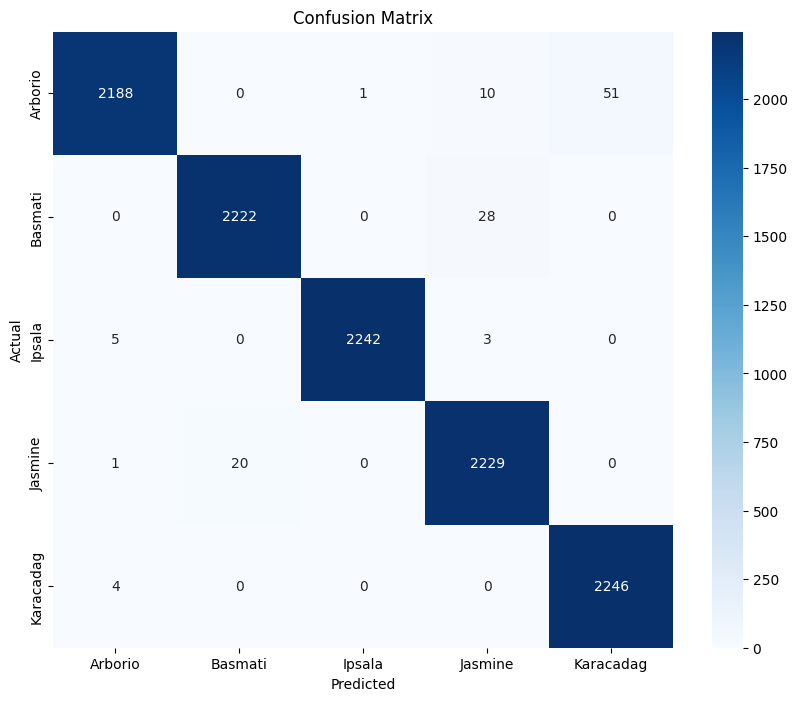

In [17]:
Class_labels = ['Arborio', 'Basmati', 'Ipsala', 'Jasmine', 'Karacadag']

model1.eval()
all_labels = []
all_predictions = []

with torch.no_grad():
    for images, labels in validation_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model1(images)
        _, predicted = torch.max(outputs.data, 1)
        
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

conf_matrix = confusion_matrix(all_labels, all_predictions)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=Class_labels, yticklabels=Class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

**8.2 Training and Validation Performance Comparison**

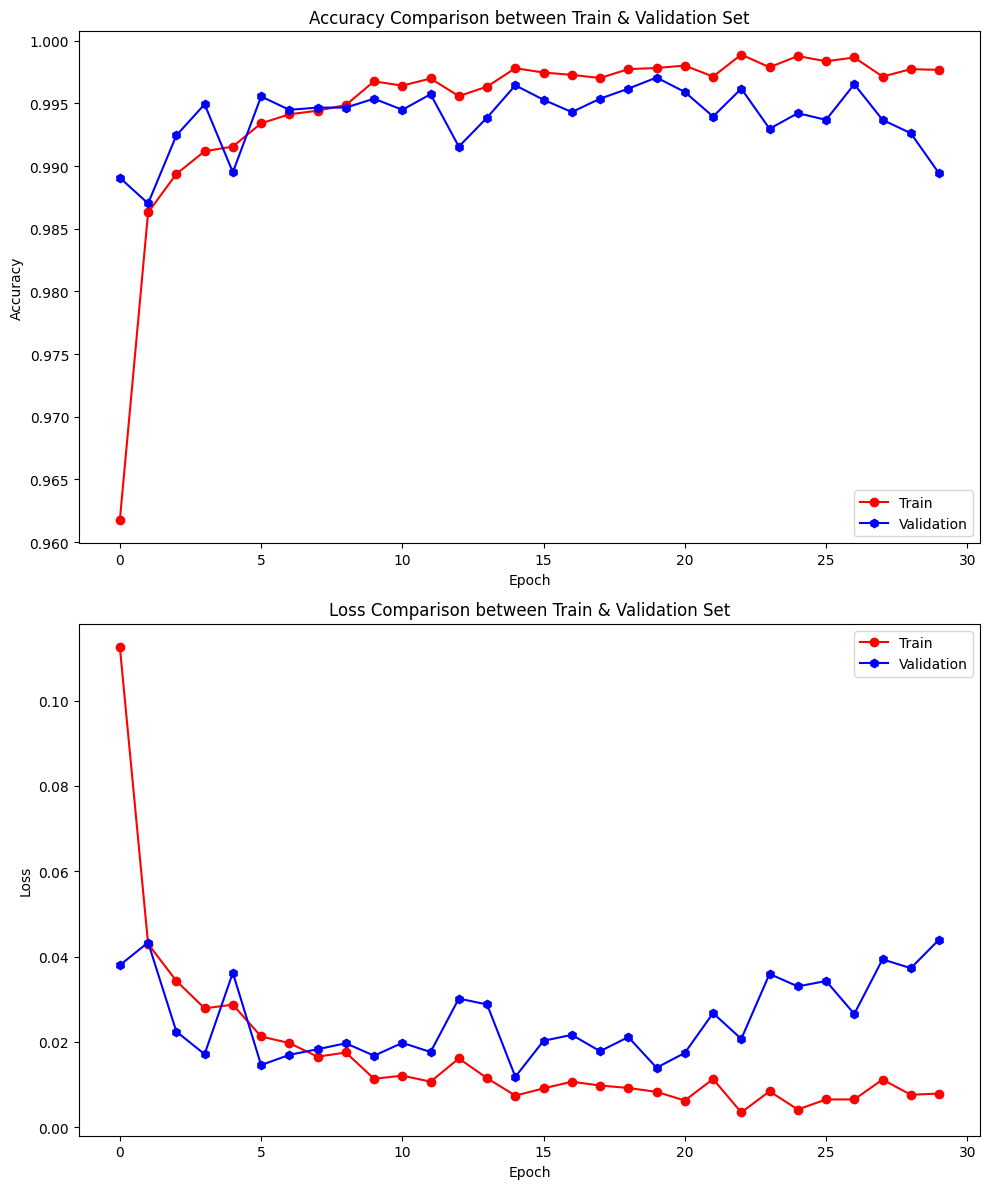

In [18]:
# Plot train and validation accuracy
fig, axs = plt.subplots(2, 1, figsize=(10, 12))
    
axs[0].plot(train_acc_history, color="red", marker="o")
axs[0].plot(val_acc_history, color="blue", marker="h")
axs[0].set_title('Accuracy Comparison between Train & Validation Set')
axs[0].set_ylabel('Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].legend(['Train', 'Validation'], loc="lower right")
    
# Plot train and validation loss
axs[1].plot(train_loss_history, color="red", marker="o")
axs[1].plot(val_loss_history, color="blue", marker="h")
axs[1].set_title('Loss Comparison between Train & Validation Set')
axs[1].set_ylabel('Loss')
axs[1].set_xlabel('Epoch')
axs[1].legend(['Train', 'Validation'], loc="upper right")

plt.tight_layout()
plt.show()

In [19]:
summary(model1, (3, 250, 250))

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 32, 250, 250]        896
├─MaxPool2d: 1-2                         [-1, 32, 125, 125]        --
├─Conv2d: 1-3                            [-1, 64, 125, 125]        18,496
├─MaxPool2d: 1-4                         [-1, 64, 62, 62]          --
├─Linear: 1-5                            [-1, 120]                 29,522,040
├─Linear: 1-6                            [-1, 84]                  10,164
├─Linear: 1-7                            [-1, 5]                   425
Total params: 29,552,021
Trainable params: 29,552,021
Non-trainable params: 0
Total mult-adds (M): 371.53
Input size (MB): 0.72
Forward/backward pass size (MB): 22.89
Params size (MB): 112.73
Estimated Total Size (MB): 136.34


Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 32, 250, 250]        896
├─MaxPool2d: 1-2                         [-1, 32, 125, 125]        --
├─Conv2d: 1-3                            [-1, 64, 125, 125]        18,496
├─MaxPool2d: 1-4                         [-1, 64, 62, 62]          --
├─Linear: 1-5                            [-1, 120]                 29,522,040
├─Linear: 1-6                            [-1, 84]                  10,164
├─Linear: 1-7                            [-1, 5]                   425
Total params: 29,552,021
Trainable params: 29,552,021
Non-trainable params: 0
Total mult-adds (M): 371.53
Input size (MB): 0.72
Forward/backward pass size (MB): 22.89
Params size (MB): 112.73
Estimated Total Size (MB): 136.34

# **9. Conclusion**

In this series of training epochs, we have witnessed the remarkable progression and fine-tuning of our model's performance. The training loss consistently decreased, reaching as low as 0.0049 by the final epoch, which indicates how well the model learned to minimize errors during training. This is mirrored by the remarkable increase in training accuracy, where our model reached an impressive 99.88% accuracy on the training set.

Furthermore, we observed the model's proficiency in generalization, as it effectively maintained its accuracy on previously unseen data. The validation loss remained relatively low, staying around 0.0252 at the end of training, and the validation accuracy consistently hovered at an impressive 99.64%. This outcome demonstrates our model's ability to accurately classify images from the validation set, highlighting its robustness beyond the training data.

Overall, the results from these training epochs showcase the effectiveness of the model's learning process and its capacity to generalize its knowledge to unseen data, thus validating its potential for accurate classification within the given context.

The End